In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
blocks = gpd.read_file('https://data.cityofchicago.org/api/geospatial/mfzt-js4n?method=export&format=Shapefile')
# Data processing
blocks['block_group_id'] = blocks.geoid10.str[0:-3]
# Dissolve blocks by block group id
blockgroups = blocks.dissolve(by='block_group_id')
# Dissolve removes the original CRS, so we need to reset it
blockgroups.crs = "EPSG:4326"

In [54]:
blockgroups = blockgroups.reset_index()
blockgroups = blockgroups[['block_group_id', 'geometry']].rename(columns={"block_group_id": "geo_12"})
blockgroups['geo_12'] = pd.to_numeric(blockgroups['geo_12'])

In [48]:
blockgroups.head(3)

,geo_12,geometry
0,170310101001,"POLYGON ((-87.67009 42.02115, -87.67047 42.021..."
1,170310101002,"POLYGON ((-87.66950 42.01936, -87.66963 42.019..."
2,170310101003,"POLYGON ((-87.66681 42.01924, -87.66780 42.019..."


In [33]:
df_preds = pd.read_csv('./mlproject_collab/covid-chicago-mobility/COVID_mobility_predictions (1).csv')

In [34]:
df_preds.head(3)

,geo_12,automotive_repair_and_maintenance,child_day_care_services,elementary_and_secondary_schools,grocery_stores,health_and_personal_care_stores,"museums,_historical_sites,_and_similar_institutions",offices_of_physicians,other_amusement_and_recreation_industries,religious_organizations,...,Percent_No_Internet_Access,Percent_Computing_Device,fraction_of_devices_home_adj,fraction_of_devices_work_adj,avg_time_away_all_adj,avg_time_away_leave_adj,pred_fraction_of_devices_work_adj,pred_avg_time_away_all_adj,intervention_fodw,intervention_ataa
0,170310101001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.217742,0.782258,-0.276869,0.021063,1.041675,-1.006553,0.026217,0.819962,1,1
1,170310101002,0.0,1.0,1.0,0.0,0.0,3.0,1.0,2.0,1.0,...,0.330517,0.829989,-0.202135,0.110128,0.348084,-1.376875,0.109401,0.467229,0,1
2,170310101003,0.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0,1.0,...,0.074041,0.950045,-0.217261,0.130307,-0.335746,-3.106318,0.122128,-0.433011,0,1


### Percent Overlap

In [35]:
df_grouped = df_preds.groupby(['intervention_fodw']).intervention_ataa.agg(["sum","count"]).reset_index()
df_grouped['percent_intervention_ataa'] = df_grouped['sum'] / df_grouped['count']
df_grouped

,intervention_fodw,sum,count,percent_intervention_ataa
0,0,472,1214,0.388797
1,1,664,967,0.686660


#### 69% of block groups past the intervention threshold for Fraction of Devices Work also fell above the threshold for Average Time Away All

In [50]:
df_grouped = df_preds.groupby(['intervention_ataa']).intervention_fodw.agg(["sum","count"]).reset_index()
df_grouped['percent_intervention_fodw'] = df_grouped['sum'] / df_grouped['count']
df_grouped

,intervention_ataa,sum,count,percent_intervention_fodw
0,0,303,1045,0.289952
1,1,664,1136,0.584507


#### 58% of block groups warranting an intervention under Average Time Away All also warranted an intervention for Fraction of Devices Work

### Maps

In [55]:
df_preds['geo_12'] = pd.to_numeric(df_preds['geo_12'])
merged_gdf = (gpd.GeoDataFrame(blockgroups.merge(df_preds, on="geo_12", how="inner"), 
                               crs=blockgroups.crs))

In [78]:
merged_gdf['Interventions'] = None

mask = (merged_gdf['intervention_ataa'] == 1) & (merged_gdf['intervention_fodw'] == 1)
merged_gdf.loc[mask, 'Interventions'] = 'Both'


mask = (merged_gdf['intervention_ataa'] == 0) & (merged_gdf['intervention_fodw'] == 1)
merged_gdf.loc[mask, 'Interventions'] = 'AvgTimeAwayAll'

mask = (merged_gdf['intervention_ataa'] == 1) & (merged_gdf['intervention_fodw'] == 0)
merged_gdf.loc[mask, 'Interventions'] = 'FractionDevicesWork'

mask = (merged_gdf['intervention_ataa'] == 0) & (merged_gdf['intervention_fodw'] == 0)
merged_gdf.loc[mask, 'Interventions'] = 'Neither'



In [72]:
merged_gdf.head(10)

,geo_12,geometry,automotive_repair_and_maintenance,child_day_care_services,elementary_and_secondary_schools,grocery_stores,health_and_personal_care_stores,"museums,_historical_sites,_and_similar_institutions",offices_of_physicians,other_amusement_and_recreation_industries,...,Percent_Computing_Device,fraction_of_devices_home_adj,fraction_of_devices_work_adj,avg_time_away_all_adj,avg_time_away_leave_adj,pred_fraction_of_devices_work_adj,pred_avg_time_away_all_adj,intervention_fodw,intervention_ataa,Interventions
0,170310101001,"POLYGON ((-87.67009 42.02115, -87.67047 42.021...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.782258,-0.276869,0.021063,1.041675,-1.006553,0.026217,0.819962,1,1,Both
1,170310101002,"POLYGON ((-87.66950 42.01936, -87.66963 42.019...",0.0,1.0,1.0,0.0,0.0,3.0,1.0,2.0,...,0.829989,-0.202135,0.110128,0.348084,-1.376875,0.109401,0.467229,0,1,FractionDevicesWork
2,170310101003,"POLYGON ((-87.66681 42.01924, -87.66780 42.019...",0.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0,...,0.950045,-0.217261,0.130307,-0.335746,-3.106318,0.122128,-0.433011,0,1,FractionDevicesWork
3,170310102011,"POLYGON ((-87.68234 42.01250, -87.68268 42.012...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.921598,-0.267492,0.152968,1.797194,0.359257,0.152513,1.800252,0,0,None
4,170310102012,"POLYGON ((-87.67972 42.01392, -87.68003 42.013...",1.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.822868,-0.180690,0.148699,0.328373,-1.291540,0.149208,0.472362,0,1,FractionDevicesWork
5,170310102013,"POLYGON ((-87.68010 42.01254, -87.68027 42.012...",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.939880,-0.147072,0.052949,0.945805,0.279977,0.091395,1.171009,1,0,AvgTimeAwayAll
6,170310102021,"POLYGON ((-87.67217 42.01596, -87.67223 42.015...",2.0,2.0,1.0,3.0,4.0,0.0,2.0,2.0,...,0.800000,-0.172711,0.099712,0.487653,-0.925782,0.103713,0.643693,0,1,FractionDevicesWork
7,170310102022,"POLYGON ((-87.67384 42.01265, -87.67418 42.012...",0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,...,0.949324,-0.191718,0.101809,0.306481,-1.581553,0.103522,0.414869,0,1,FractionDevicesWork
8,170310103001,"POLYGON ((-87.66271 42.01616, -87.66268 42.015...",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.919662,-0.273688,0.130518,0.348331,-3.031294,0.130564,0.573109,0,1,FractionDevicesWork
9,170310103002,"POLYGON ((-87.66818 42.01712, -87.66861 42.017...",0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.798174,-0.172531,0.113555,0.211471,-1.989842,0.110559,0.168974,0,1,FractionDevicesWork


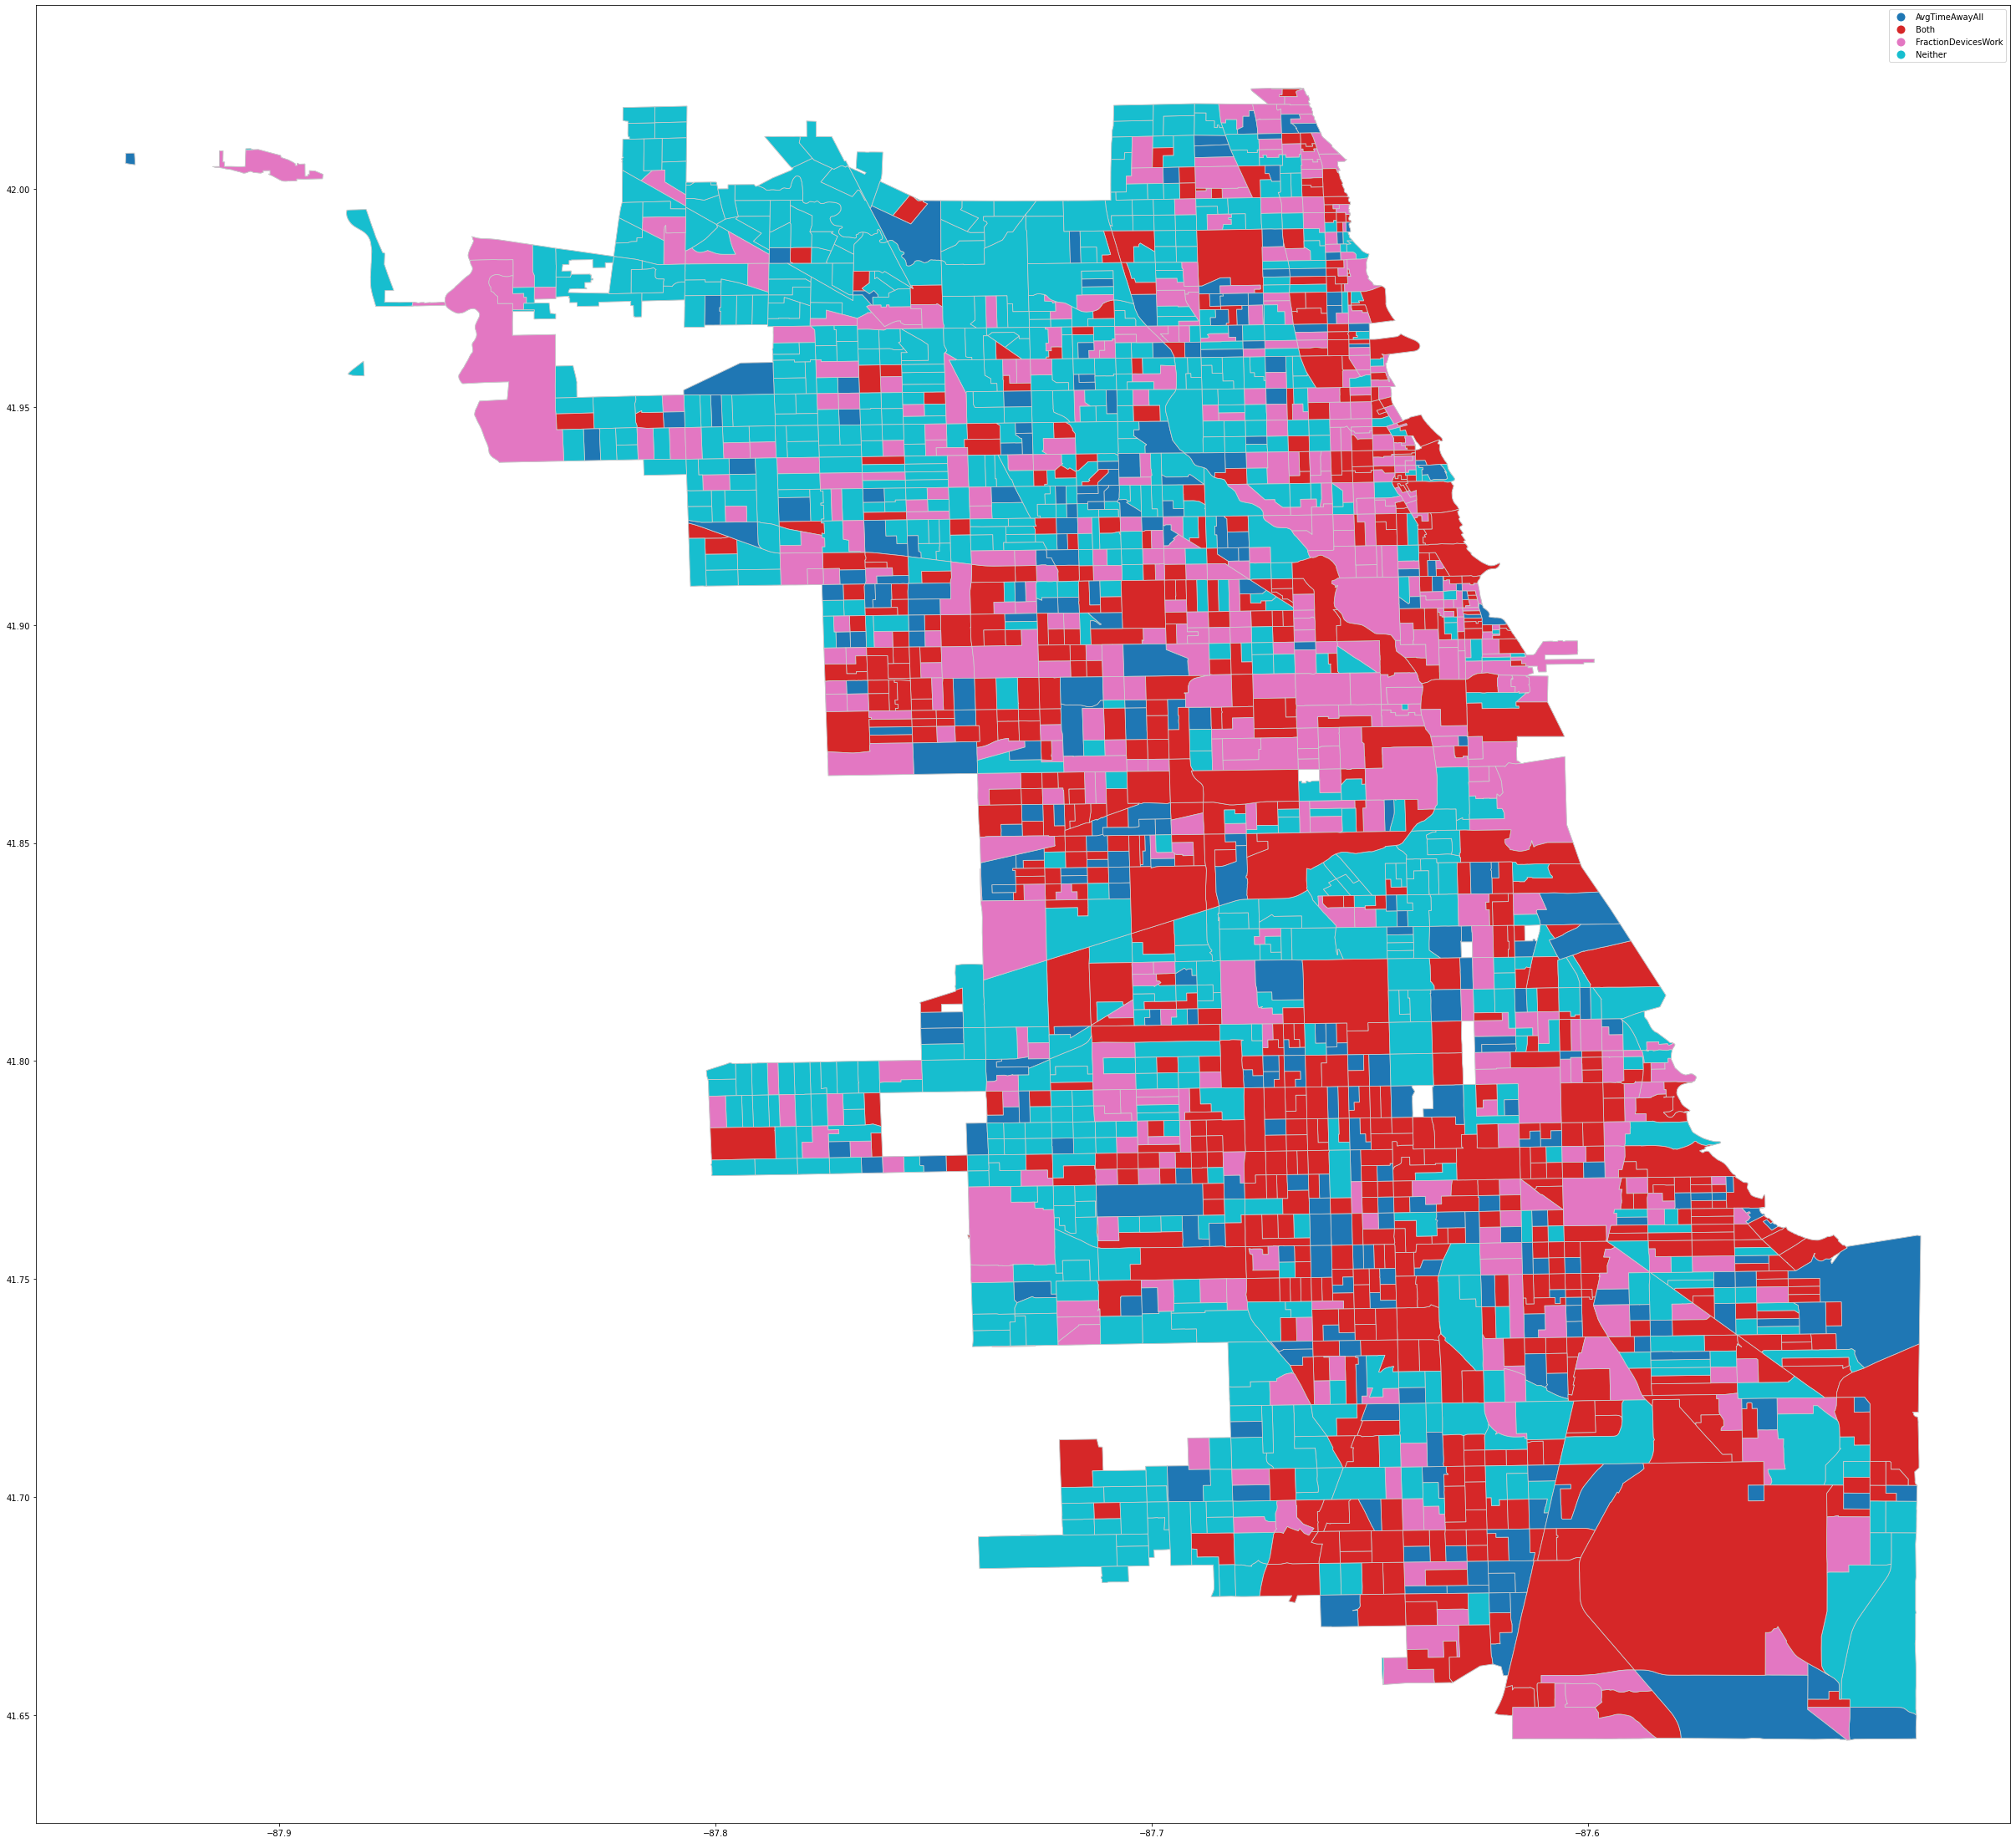

In [84]:
fig, ax = plt.subplots(1, figsize=(50, 40))
merged_gdf.plot(linewidth=0.8, ax=ax, edgecolor='0.8', missing_kwds={'color': 'lightgrey'})
merged_gdf.plot(column = 'Interventions',linewidth=0.8, ax=ax, cmap='tab10', edgecolor='0.8', legend=True)

